In [1]:
import ssl
import pandas as pd
from math import ceil, sqrt
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
from numpy import isnan, nan, arange, meshgrid, c_
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB


In [14]:
if getattr(ssl, '_create_unverified_context', None):
    ssl._create_default_https_context = ssl._create_unverified_context
d = pd.read_csv("https://raw.githubusercontent.com/mayraberrones94/Ciencia_de_Datos/master/bp_w-data.csv")
d.diagnosis.replace(to_replace = dict(M = 1, B = 0), inplace = True)

m = d.loc[d.diagnosis == 1]
b = d.loc[d.diagnosis == 0]
print(m.radius_mean.max(), m.radius_worst.max())
print(m.radius_mean.min(), m.radius_worst.min())
print(b.radius_mean.max(), b.radius_worst.max())
print(b.radius_mean.min(), b.radius_worst.min())



28.11 36.04
10.95 12.84
17.85 19.82
6.981 7.93


0    392
1     92
2     85
Name: etiquetas, dtype: int64


/Users/mayraberrones/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpc.py:434: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.5571431 ,  1.59841796]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 112, 'nit': 13, 'warnflag': 2}
  ConvergenceWarning)
/Users/mayraberrones/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpc.py:434: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.78246569, -1.98552466]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 121, 'nit': 12, 'warnflag': 2}
  ConvergenceWarning)


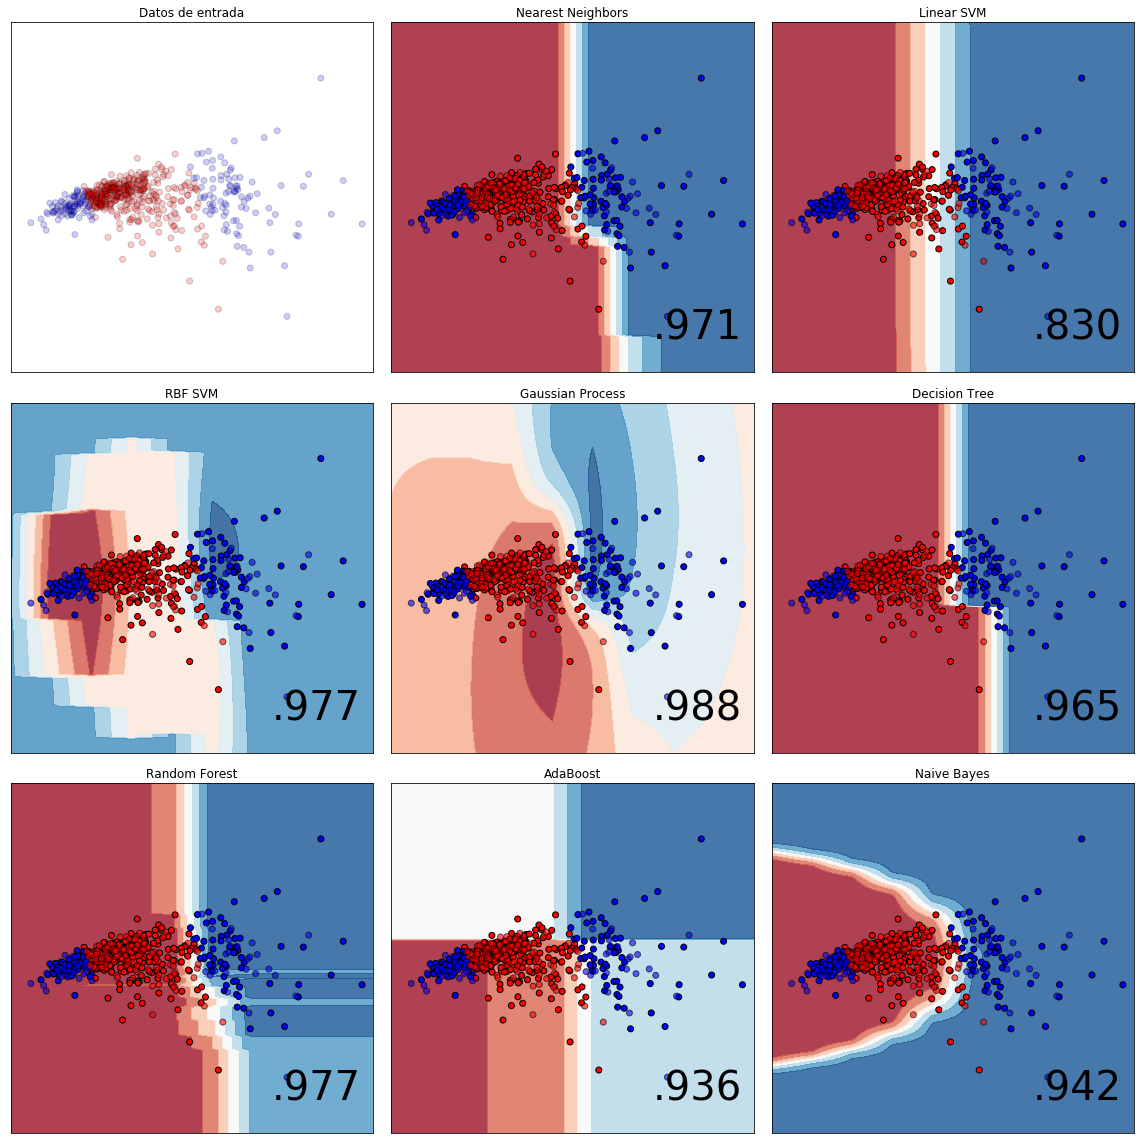

In [15]:
pri = d.radius_mean >= 18
seg = d.radius_mean <= 11
ter = ~pri & ~seg

d['etiquetas'] = [1 if  pri[i] else (2 if seg[i] else (0 if ter[i] else "NA")) for i in pri.keys()] # etiquetas
print(d.etiquetas.value_counts())
y = d.etiquetas
xVars = ['radius_mean', 'radius_worst']
x = d.loc[:, xVars].values
x = StandardScaler().fit_transform(x)
pca = PCA(n_components = 2) # pedimos uno bidimensional
X = pca.fit_transform(x)
# código de https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html 
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process", \
         "Decision Tree", "Random Forest", "AdaBoost", "Naive Bayes"]
classifiers = [KNeighborsClassifier(3), SVC(kernel="linear", C=0.025), \
    SVC(gamma=2, C=1), GaussianProcessClassifier(1.0 * RBF(1.0)), \
    DecisionTreeClassifier(max_depth=5), RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1), \
    AdaBoostClassifier(), GaussianNB()]
k = int(ceil(sqrt(len(classifiers) + 1)))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42) # división
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = meshgrid(arange(x_min, x_max), arange(y_min, y_max, 0.02))
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
plt.rcParams["figure.figsize"] = [16, 16]
figure = plt.figure()
ax = plt.subplot(k, k, 1)
ax.set_title("Datos de entrada")
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, alpha=0.2, edgecolors='k') # entrenamiento
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.2, edgecolors='k') # validación
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())
i = 2
for name, clf in zip(names, classifiers):
    ax = plt.subplot(k, k, i)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(c_[xx.ravel(), yy.ravel()])[:, 1]
    else:
        Z = clf.predict_proba(c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors='k')
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, edgecolors='k', alpha=0.6)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(name)
    ax.text(xx.max() - .3, yy.min() + .3, ('%.3f' % score).lstrip('0'), size=40, horizontalalignment='right')
    i += 1
plt.tight_layout()
plt.show()

In [16]:
import ssl
import pandas as pd
from math import ceil, sqrt
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
from numpy import isnan, nan
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process", \
         "Decision Tree", "Random Forest", "AdaBoost", "Naive Bayes"]
classifiers = [KNeighborsClassifier(3), SVC(kernel="linear", C=0.025), \
    SVC(gamma=2, C=1), GaussianProcessClassifier(1.0 * RBF(1.0)), \
    DecisionTreeClassifier(max_depth=5), RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1), \
    AdaBoostClassifier(), GaussianNB()]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42) # la misma división
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    print(name, clf.score(X_test, y_test))
    expected, predicted = y_test, clf.predict(X_test)
    print(metrics.classification_report(expected, predicted))
    print(metrics.confusion_matrix(expected, predicted))
    print('-' * 60)

Nearest Neighbors 0.9707602339181286
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       117
           1       0.86      1.00      0.93        25
           2       0.97      1.00      0.98        29

   micro avg       0.97      0.97      0.97       171
   macro avg       0.94      0.99      0.96       171
weighted avg       0.97      0.97      0.97       171

[[112   4   1]
 [  0  25   0]
 [  0   0  29]]
------------------------------------------------------------
Linear SVM 0.8304093567251462
              precision    recall  f1-score   support

           0       0.82      0.97      0.89       117
           1       0.86      1.00      0.93        25
           2       1.00      0.14      0.24        29

   micro avg       0.83      0.83      0.83       171
   macro avg       0.89      0.70      0.68       171
weighted avg       0.86      0.83      0.78       171

[[113   4   0]
 [  0  25   0]
 [ 25   0   4]]
------------------

/Users/mayraberrones/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpc.py:434: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.5571431 ,  1.59841796]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 112, 'nit': 13, 'warnflag': 2}
  ConvergenceWarning)


Gaussian Process 0.9883040935672515
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       117
           1       0.93      1.00      0.96        25
           2       1.00      1.00      1.00        29

   micro avg       0.99      0.99      0.99       171
   macro avg       0.98      0.99      0.98       171
weighted avg       0.99      0.99      0.99       171

[[115   2   0]
 [  0  25   0]
 [  0   0  29]]
------------------------------------------------------------
Decision Tree 0.9649122807017544
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       117
           1       0.93      1.00      0.96        25
           2       0.93      0.93      0.93        29

   micro avg       0.96      0.96      0.96       171
   macro avg       0.95      0.97      0.96       171
weighted avg       0.97      0.96      0.96       171

[[113   2   2]
 [  0  25   0]
 [  2   0  27]]
----------------

/Users/mayraberrones/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpc.py:434: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.78246569, -1.98552466]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 121, 'nit': 12, 'warnflag': 2}
  ConvergenceWarning)


/Users/mayraberrones/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpc.py:434: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.22491718,  3.58483224]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 85, 'nit': 10, 'warnflag': 2}
  ConvergenceWarning)


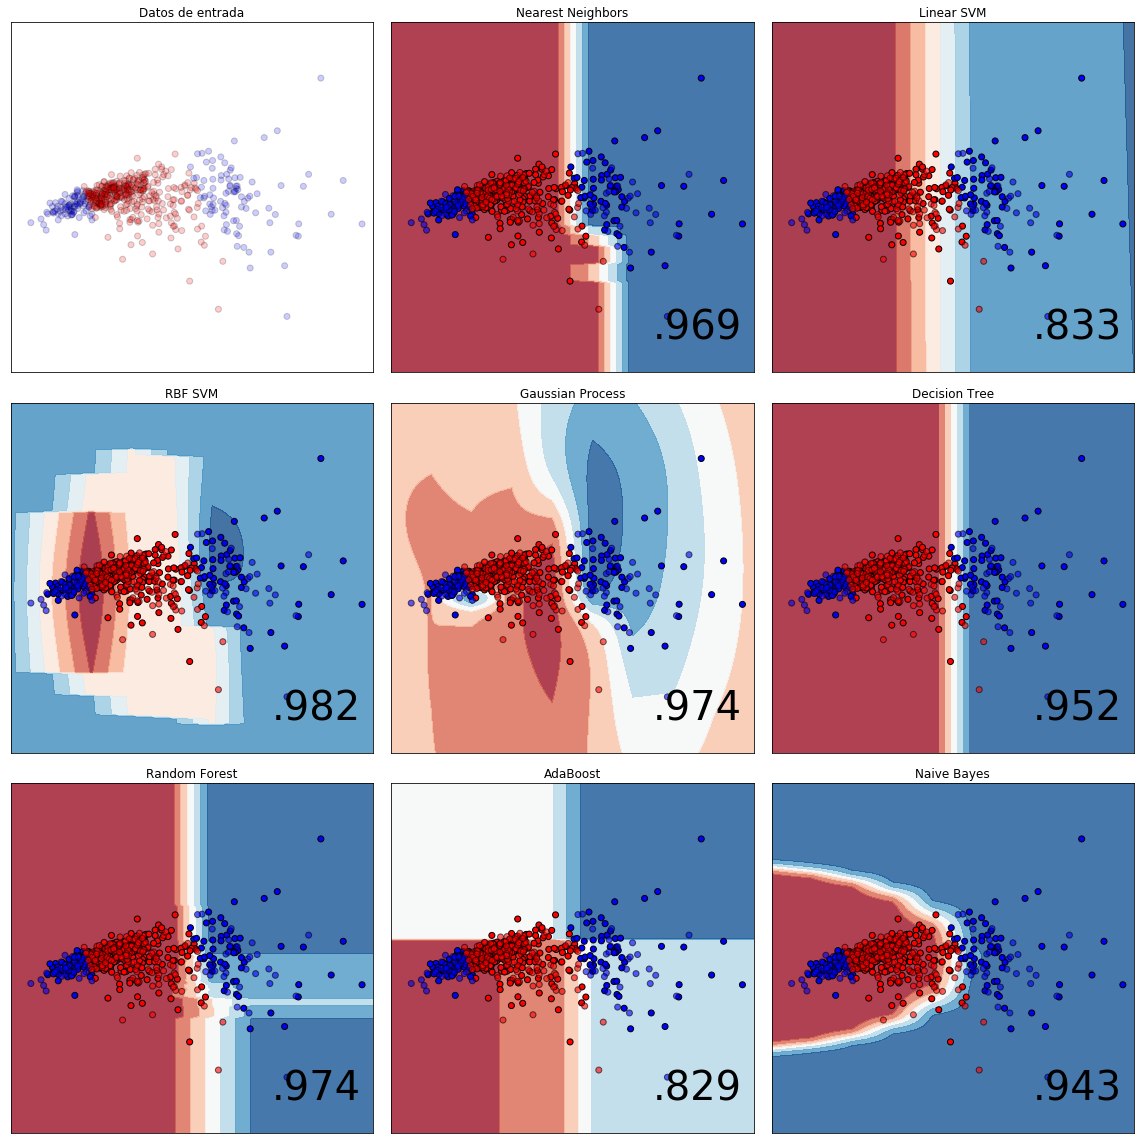

In [23]:
import ssl
import pandas as pd
from math import ceil, sqrt
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
from numpy import isnan, nan, arange, meshgrid, c_
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
                                                                                                                  

# código de https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html 
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process", \
         "Decision Tree", "Random Forest", "AdaBoost", "Naive Bayes"]
classifiers = [KNeighborsClassifier(3), SVC(kernel="linear", C=0.025), \
    SVC(gamma=2, C=1), GaussianProcessClassifier(1.0 * RBF(1.0)), \
    DecisionTreeClassifier(max_depth=5), RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1), \
    AdaBoostClassifier(), GaussianNB()]
k = int(ceil(sqrt(len(classifiers) + 1)))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=42) # división
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = meshgrid(arange(x_min, x_max), arange(y_min, y_max, 0.02))
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
plt.rcParams["figure.figsize"] = [16, 16]
figure = plt.figure()
ax = plt.subplot(k, k, 1)
ax.set_title("Datos de entrada")
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, alpha=0.2, edgecolors='k') # entrenamiento
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.2, edgecolors='k') # validación
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())
i = 2
for name, clf in zip(names, classifiers):
    ax = plt.subplot(k, k, i)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(c_[xx.ravel(), yy.ravel()])[:, 1]
    else:
        Z = clf.predict_proba(c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors='k')
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, edgecolors='k', alpha=0.6)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(name)
    ax.text(xx.max() - .3, yy.min() + .3, ('%.3f' % score).lstrip('0'), size=40, horizontalalignment='right')
    i += 1
plt.tight_layout()
plt.show()

In [24]:
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process", \
         "Decision Tree", "Random Forest", "AdaBoost", "Naive Bayes"]
classifiers = [KNeighborsClassifier(3), SVC(kernel="linear", C=0.025), \
    SVC(gamma=2, C=1), GaussianProcessClassifier(1.0 * RBF(1.0)), \
    DecisionTreeClassifier(max_depth=5), RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1), \
    AdaBoostClassifier(), GaussianNB()]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=42) # la misma división
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    print(name, clf.score(X_test, y_test))
    expected, predicted = y_test, clf.predict(X_test)
    print(metrics.classification_report(expected, predicted))
    print(metrics.confusion_matrix(expected, predicted))
    print('-' * 60)

Nearest Neighbors 0.9692982456140351
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       158
           1       0.89      1.00      0.94        32
           2       0.93      1.00      0.96        38

   micro avg       0.97      0.97      0.97       228
   macro avg       0.94      0.99      0.96       228
weighted avg       0.97      0.97      0.97       228

[[151   4   3]
 [  0  32   0]
 [  0   0  38]]
------------------------------------------------------------
Linear SVM 0.8333333333333334
              precision    recall  f1-score   support

           0       0.82      0.97      0.89       158
           1       0.86      1.00      0.93        32
           2       1.00      0.13      0.23        38

   micro avg       0.83      0.83      0.83       228
   macro avg       0.90      0.70      0.68       228
weighted avg       0.86      0.83      0.79       228

[[153   5   0]
 [  0  32   0]
 [ 33   0   5]]
------------------

/Users/mayraberrones/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpc.py:434: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.22491718,  3.58483224]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 85, 'nit': 10, 'warnflag': 2}
  ConvergenceWarning)


Gaussian Process 0.9736842105263158
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       158
           1       0.84      1.00      0.91        32
           2       1.00      0.89      0.94        38

   micro avg       0.97      0.97      0.97       228
   macro avg       0.95      0.96      0.95       228
weighted avg       0.98      0.97      0.97       228

[[156   2   0]
 [  0  32   0]
 [  0   4  34]]
------------------------------------------------------------
Decision Tree 0.9517543859649122
              precision    recall  f1-score   support

           0       1.00      0.93      0.96       158
           1       0.84      1.00      0.91        32
           2       0.88      1.00      0.94        38

   micro avg       0.95      0.95      0.95       228
   macro avg       0.91      0.98      0.94       228
weighted avg       0.96      0.95      0.95       228

[[147   6   5]
 [  0  32   0]
 [  0   0  38]]
----------------